In [ ]:
# !pip install numpy pandas seaborn matplotlib scikit-learn safetensors
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# # reben requiring python > 3.9  but < 3.12
# !pip install git+https://git.tu-berlin.de/rsim/reben-training-scripts.git
# !pip install configilm torchsummary

In [1]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

2048

### Train model on wealth index directly

Baseline of taking mean gives mse of 0.03. Models below do explain something then? freezing model weights or not does not seem to make a difference. **direct vit base** seems to give most reasonable looking results.

In [148]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth Index - Scaled':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target.drop(columns='DHSCLUST', inplace=True)
df_target = df_target.astype({'target':'float32'})

In [149]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [150]:
# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [151]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 1m 31s


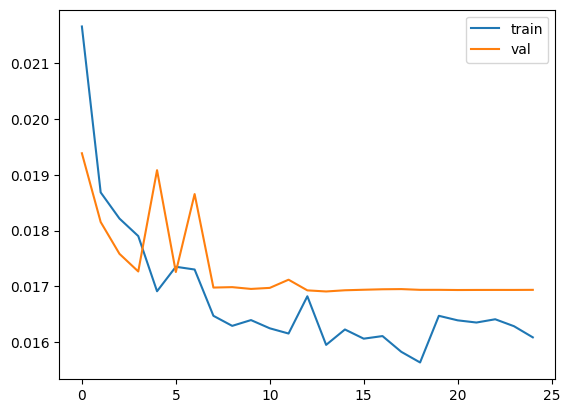

In [152]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

In [153]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

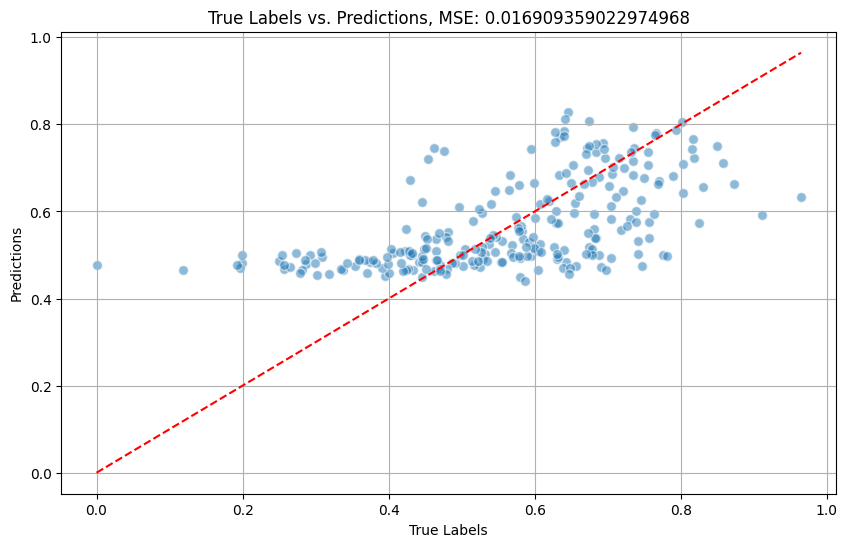

In [154]:
import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()

In [186]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import mean_squared_error

In [187]:
model_reg = models.resnet101(pretrained=True)

# Freeze all weights
for param in model_reg.parameters():
    param.requires_grad = False

# Modify the model for regression by replacing head. new modules have requires_grad=True by default
num_features = model_reg.fc.in_features  # Get the number of input features to the final layer

# Just one simple layer
model_reg.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()\
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Calculate the number of trainable parameters
trainable_params = sum(p.numel() for p in model_reg.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {trainable_params}")

/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tfc/anaconda3/envs/sat_dl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of trainable parameters: 2049


In [188]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth Index - Scaled':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target.drop(columns='DHSCLUST', inplace=True)
df_target = df_target.astype({'target':'float32'})

In [189]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [190]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 0m 47s


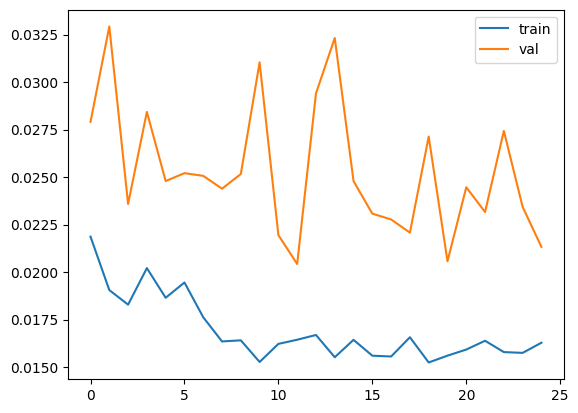

In [191]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

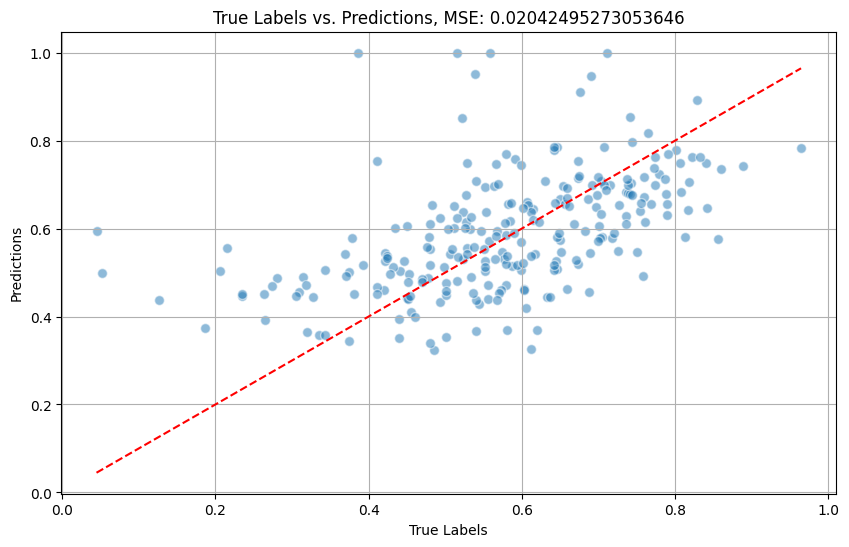

In [192]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

#### direct vit base (freeze)

In [167]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, ConvNextV2Model
import timm

from sklearn.metrics import mean_squared_error

In [182]:
class ConvNeXtForRegression(nn.Module):
    def __init__(self, base_model):
        super(ConvNeXtForRegression, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 1),
            nn.Sigmoid()
        )

        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = ConvNeXtForRegression(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [183]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [184]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth Index - Scaled':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target.drop(columns='DHSCLUST', inplace=True)
df_target = df_target.astype({'target':'float32'})

In [185]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [186]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 1m 7s


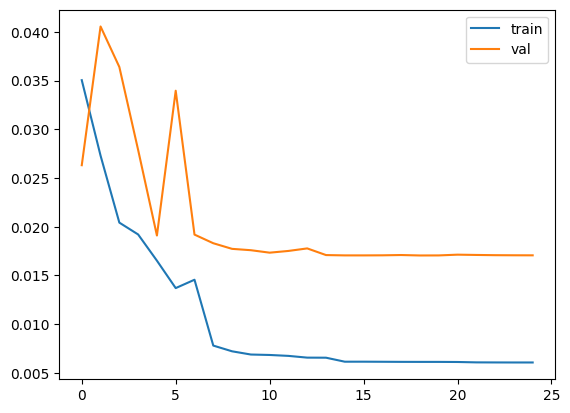

In [187]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

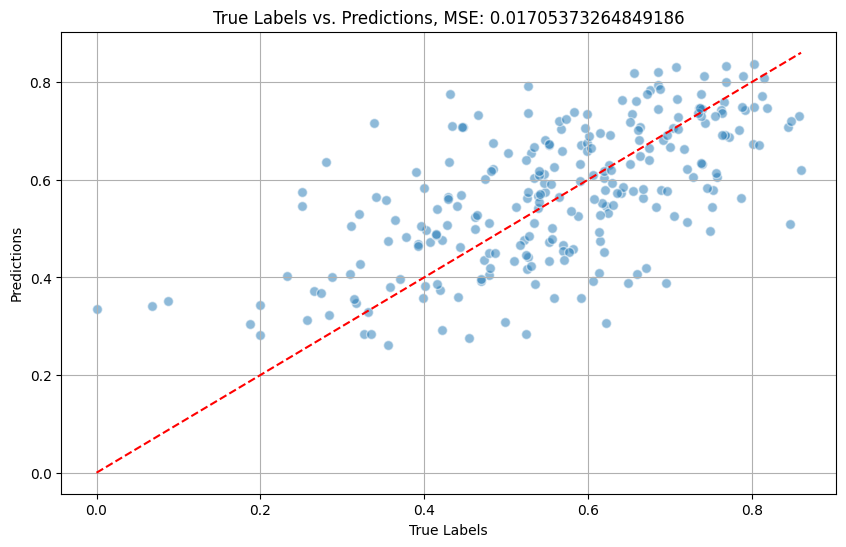

In [188]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

### Train model on nightlight

In [250]:
class AddChannels(torch.nn.Module):
    def __init__(self, n_channels=10):
        super(AddChannels, self).__init__()
        self.n_channels = n_channels

    def forward(self, img):
        # Ensure the image is in tensor format
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        
        # Add channels
        current_channels, height, width = img.size()
        if current_channels != self.n_channels:
            extra_channels = torch.zeros((self.n_channels-current_channels, height, width),dtype=img.dtype)
            new_img = torch.cat([img, extra_channels], dim=0)
        else:
            new_img = img
        
        # Ensure label is returned as is or apply transformations if needed
        return new_img.float()

# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                            # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.ToTensor(),                                # Convert the image to a tensor
    AddChannels(n_channels=10),                           # Add extra channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406,0,0,0,0,0,0,0],      # Normalize with ImageNet mean and std (common for pretrained models)
                         std=[0.229, 0.224, 0.225,1,1,1,1,1,1,1])
])

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [251]:
# Load target information
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target = df_target[['filename','target']]
df_target = df_target.astype({'target':'float32'})

In [252]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
}

In [253]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([25]), 'val':np.zeros([25])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Training complete in 1m 38s


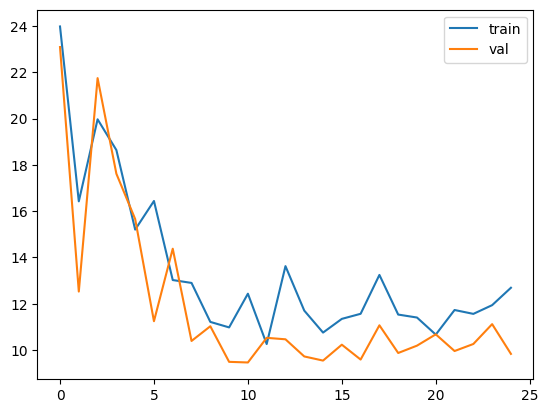

In [254]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25,verbose=0,plot_curves=True)

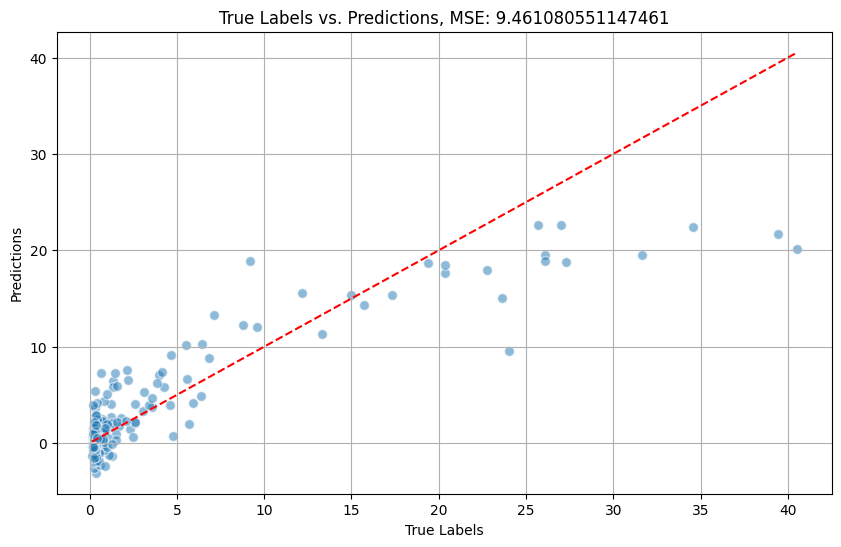

In [255]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

import matplotlib.pyplot as plt

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.show()

In [256]:
import torch
import torch.nn as nn
from torchvision import models


# Calculate the number of trainable parameters
trainable_params = sum(p.numel() for p in model_reg.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {trainable_params}")


Number of trainable parameters: 42524161


#### direct vit base (freeze)

In [102]:
# Deep learning
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, ConvNextV2Model
import timm

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [119]:
class ConvNeXtForRegression(nn.Module):
    def __init__(self, base_model):
        super(ConvNeXtForRegression, self).__init__()
        self.backbone = base_model
        # Add a regression head
        self.fc = nn.Sequential(
            nn.Linear(base_model.num_features, 512),  # First layer
            nn.BatchNorm1d(512),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            nn.Dropout(0.3),                          # Dropout for regularization
            
            nn.Linear(512, 256),                      # Second layer
            nn.BatchNorm1d(256),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            nn.Dropout(0.3),                          # Dropout for regularization
            
            nn.Linear(256, 128),                      # Third layer
            nn.BatchNorm1d(128),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            
            nn.Linear(128, 1),                        # Output layer
        )
        
        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = ConvNeXtForRegression(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [120]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
}

In [122]:
# Load target information, log transform then min max scale
target_path = 'data'
df_target = pd.read_csv(os.path.join(target_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_target['filename'] = df_target['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target = df_target[['filename','target']]
df_target = df_target.astype({'target':'float32'})

In [123]:
# Custom Dataset class
class RegressionDataset(Dataset):
    def __init__(self, image_folder, targets_df, transform=None):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Load the full dataset
image_folder = 'data/daysat/2022/'
full_dataset = RegressionDataset(image_folder=image_folder, targets_df=df_target)

# Determine the sizes for training and validation sets
total_size = len(full_dataset)
val_size = int(0.2 * total_size)                   # About 0.2 for validation
train_size = total_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
dataset_sizes = {'train':train_size, 'val':val_size}

# Apply appropriate transforms
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
}

In [124]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,verbose=0,plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train':np.zeros([num_epochs]), 'val':np.zeros([num_epochs])})
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch,phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df

Epoch 0/9
----------
train Loss: 30.4249
val Loss: 18.9625

Epoch 1/9
----------
train Loss: 20.2486
val Loss: 6.7786

Epoch 2/9
----------
train Loss: 16.4178
val Loss: 13.7086

Epoch 3/9
----------
train Loss: 13.5647
val Loss: 6.4214

Epoch 4/9
----------
train Loss: 11.9493
val Loss: 3.8760

Epoch 5/9
----------
train Loss: 12.2461
val Loss: 3.5498

Epoch 6/9
----------
train Loss: 13.5893
val Loss: 4.1239

Epoch 7/9
----------
train Loss: 10.9986
val Loss: 10.8407

Epoch 8/9
----------
train Loss: 10.9340
val Loss: 4.2238

Epoch 9/9
----------
train Loss: 11.2168
val Loss: 4.2528

Training complete in 0m 27s


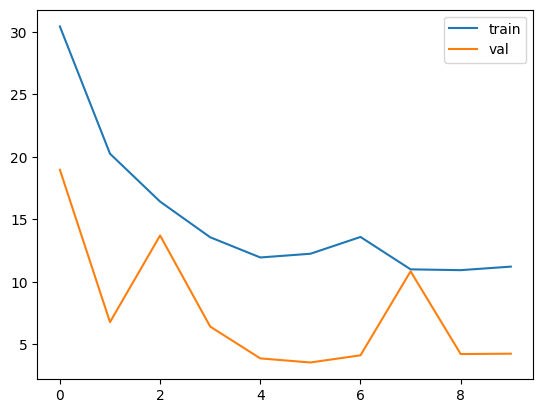

In [125]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10,verbose=1,plot_curves=True)

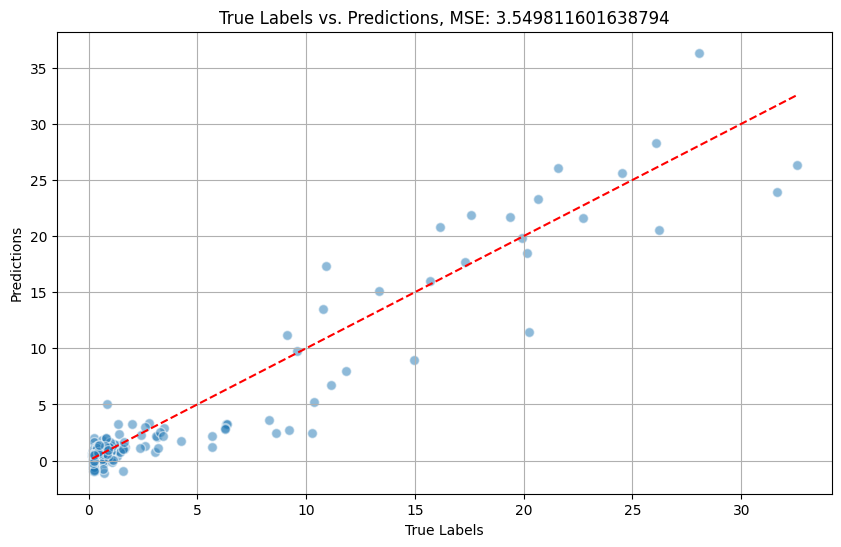

In [126]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

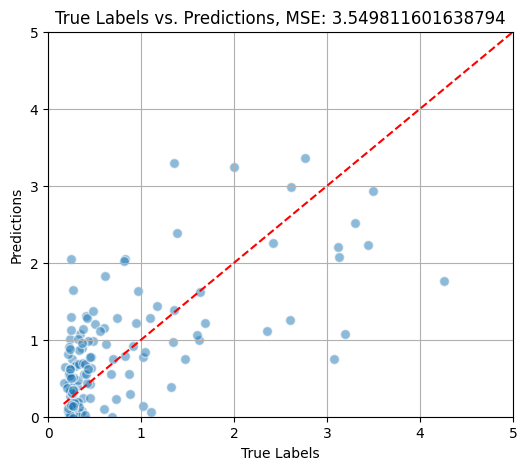

In [128]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(6, 5))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
plt.xlim([0,5])
plt.ylim([0,5]);

### Using daytime sat as additional feature

vit base seems to work best. tried for:
1. bigearthnet vit base vs direct vit base
2. log y, minmaxscale(log y), larger fc network, and larger fc network + minmaxscale(log y).

note: single linear layer ones need sigmoid to prevent exploding gradients

decided on:
1. daysat direct as additional feature - direct vit base + small network + sigmoid
2. transfer model as additional feature - direct vit base + larger fc network as additional feature

#### daysat direct